## Contents:
- [Imports](#Imports)
- [Load Data from AWS and prepare](#Load-Data-from-AWS-and-prepare)
- [Cluster Location Data](#Clustered-Location-Data)
- [Explore Target Variable Transformations](#Explore-Target-Variable-Log-Transform)
- [Model #1, OLS, not scaled. As baseline for regression.](#Model-#1,-OLS,-not-scaled.-As-baseline-for-regression.)
- [Model #2, Statsmodel for stastical significance testing](#Model-#2,-Statsmodel-for-stastical-significance-testing)
- [Model #3, Linear Regression, scaled](#Model-#3,-Linear-Regression,-scaled)
- [Model #4, Lasso Gridsearch, basic](#Model-#4,-Lasso-Gridsearch,-basic)
- [Model #5, Ridge Gridsearch, L1 penalty is not kind to our model. Trying L2.](#Model-#5,-RidgeCV,-L1-penalty-is-not-kind-to-our-model.-Trying-L2.)
- [Model #6, Elastic Search Gridsearch, Exploring Polynomial Features](#Model-#6,-Elastic-Search-Gridsearch,-Exploring-Polynomial-Features)

This notebook explores various transformations and approaches while using linear regression models. The goal of this notebook is not to produce the best performing model, but to explore techniques that may be useful in later notebooks to boost the model score and to evaluate feature importance. Ultimately, this project chooses to frame the problem as a classification instead of regression problem. From the first niave model to final model tested in this notebook with scaling, L2 regularization, feature variable log transformation, and polynomial features added there is an increase in R^2 is .005 to .13. 

#### Techniques and models explored:

|Model|R^2 Score|Technique Applied|
|---|---|---|
|Ordinary Least Squares|.005|Niave|
|Ordinary Least Squares|.124|Log Transform|
|Ordinary Least Squares|.121|Log Transform + Standard Scalar|
|Lasso Regression|.004|L1 penalty|
|Lasso Regression|.121|Log transform + L1 penalty|
|Ridge Regression|.121|Log transform + L2 penalty|
|Elastic Search|.134|Log transform + L2 penalty + polynomial features|

# Imports

In [1]:
#from google.colab import drive 
import pandas as pd
import numpy as np

# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV,ElasticNetCV, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
import statsmodels.api as sm

#set_style
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'

# Load Data from AWS and prepare

### Load

#### Read cleaned dataset from AWS

In [80]:
model_df = pd.read_csv('s3://git-to-amazon-s3-outputbucket-rorni8oehk4l/soulclimberchick/meteorology-fire-impact/data-files/mfi_df_yr_trail.csv')
model_df.dropna(inplace=True)
# model_df = pd.read_csv('./data/mfi_df_yr_latlong.csv')

model_df.drop(columns='Unnamed: 0', inplace=True)

In [79]:
# Most wildfires are class A and B or under 100 acres
model_df['fire_size_class'].value_counts(normalize = True)

A    0.614975
B    0.289087
C    0.055140
D    0.015261
E    0.011265
F    0.009046
G    0.005226
Name: fire_size_class, dtype: float64

In [81]:
model_df.head(3)

,fire_code,fire_name,complex_name,stat_cause_code,stat_cause_descr,fire_size,fire_size_class,latitude,longitude,state,...,pcp_t9m,pcp_t12m,pmdi_t3m,pmdi_t6m,pmdi_t9m,pmdi_t12m,pdsi_t3m,pdsi_t6m,pdsi_t9m,pdsi_t12m
3469,C781,PACIFIC,NO_NAME,5.0,Debris Burning,0.1,A,32.7167,-114.5008,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3470,C428,SANTEFEGAS,NO_NAME,13.0,Missing/Undefined,5.0,B,33.2000,-112.5340,AZ,...,1.332222,1.5125,2.73,3.62,3.715556,3.203333,3.463333,4.101667,4.036667,3.444167
3474,C426,JOSHUATREE,NO_NAME,9.0,Miscellaneous,0.1,A,33.8667,-112.3841,AZ,...,1.872222,1.8375,3.95,3.89,4.140000,3.655833,4.393333,4.371667,4.461111,3.896667


## Prepare

# Cluster Location Data

In [82]:
# Put lat/long into a matrix
location_data = round(model_df[['longitude', 'latitude']],4) # round to decrease grid accuracy of lat/long

# Cluster lat/long
km = KMeans(n_clusters=200)
km.fit(location_data)

# Append clusters back into model_df
model_df.loc[:, 'cluster'] = km.predict(location_data)

#### Explore model_df['month] as a one hot encode feature

In [83]:
model_df = pd.get_dummies(model_df, columns=['month'], drop_first=True) # in relation to January
model_df = pd.get_dummies(model_df, columns=['cluster']) # location clustered by lat/long

### Normal

In [84]:
#create X and y variables
X = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
       'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21',
       'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26',
       'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',
       'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36',
       'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41',
       'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46',
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56',
       'cluster_57', 'cluster_58', 'cluster_59', 'cluster_60', 'cluster_61',
       'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66',
       'cluster_67', 'cluster_68', 'cluster_69', 'cluster_70', 'cluster_71',
       'cluster_72', 'cluster_73', 'cluster_74', 'cluster_75', 'cluster_76',
       'cluster_77', 'cluster_78', 'cluster_79', 'cluster_80', 'cluster_81',
       'cluster_82', 'cluster_83', 'cluster_84', 'cluster_85', 'cluster_86',
       'cluster_87', 'cluster_88', 'cluster_89', 'cluster_90', 'cluster_91',
       'cluster_92', 'cluster_93', 'cluster_94', 'cluster_95', 'cluster_96',
       'cluster_97', 'cluster_98', 'cluster_99', 'cluster_100', 'cluster_101',
       'cluster_102', 'cluster_103', 'cluster_104', 'cluster_105',
       'cluster_106', 'cluster_107', 'cluster_108', 'cluster_109',
       'cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_169',
       'cluster_170', 'cluster_171', 'cluster_172', 'cluster_173',
       'cluster_174', 'cluster_175', 'cluster_176', 'cluster_177',
       'cluster_178', 'cluster_179', 'cluster_180', 'cluster_181',
       'cluster_182', 'cluster_183', 'cluster_184', 'cluster_185',
       'cluster_186', 'cluster_187', 'cluster_188', 'cluster_189',
       'cluster_190', 'cluster_191', 'cluster_192', 'cluster_193',
       'cluster_194', 'cluster_195', 'cluster_196', 'cluster_197',
       'cluster_198', 'cluster_199',
             'tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']]
y = model_df[['fire_size']]

assert len(X) == len(y)

In [85]:
#split into training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=.2, train_size = .8)

# Explore Target Variable Log Transform

In [86]:
#try a log on it
model_df['fire_size_log'] = np.log(model_df['fire_size'])

#log +1
model_df['fire_size_log1'] = np.log(model_df['fire_size']+1)

#log +1 normalized

#normalize function
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

model_df['fire_size_log1_norm'] = normalize(model_df['fire_size_log1'])

#cube root
model_df['fire_size_cubert'] = (model_df['fire_size']**(1/3))

#log max root
log_max = np.log(model_df['fire_size'].max())
model_df['fire_size_logmax'] = model_df['fire_size']**(1/log_max)

In [87]:
#taking the inverse of function of log(price) to convert log(price) back to fire_size
model_df['fire_size_log_to_norm'] = np.exp(model_df['fire_size_log'])
model_df[['fire_size_log', 'fire_size_log_to_norm','fire_size']]

,fire_size_log,fire_size_log_to_norm,fire_size
3469,-2.302585,0.1,0.1
3470,1.609438,5.0,5.0
3474,-2.302585,0.1,0.1
3477,-2.302585,0.1,0.1
3589,1.098612,3.0,3.0
...,...,...,...
420158,-2.302585,0.1,0.1
420159,-2.302585,0.1,0.1
420160,-2.302585,0.1,0.1
420165,3.465736,32.0,32.0


A visual look of effect of the transformations on distribution. Log transform gives the closest apperance to a normal distribution. Let's see how it compares when modeled.

#### No transformation

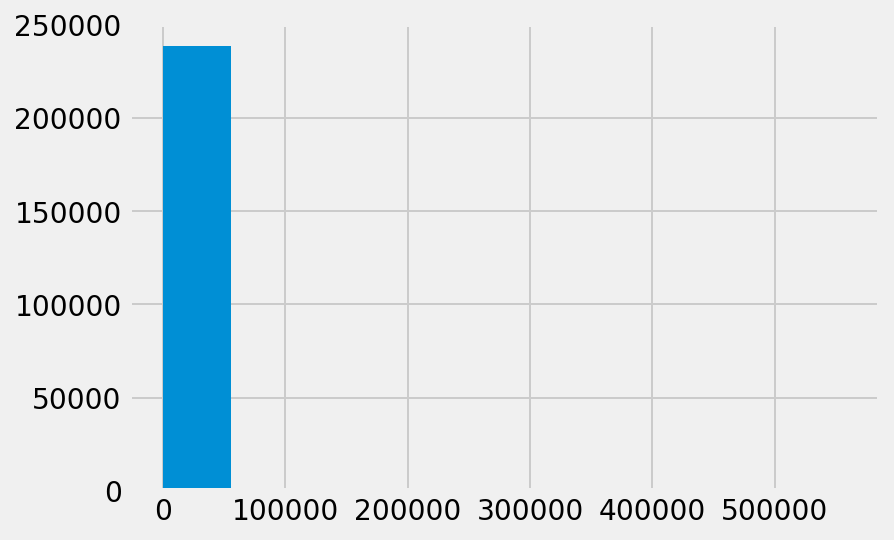

In [88]:
model_df['fire_size'].hist();

#### Log Transform

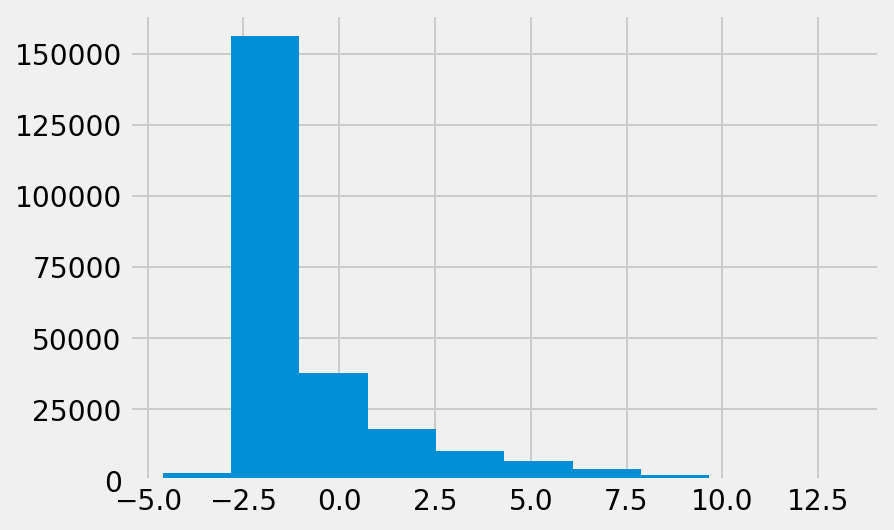

In [89]:
model_df['fire_size_log'].hist();

#### Log +1

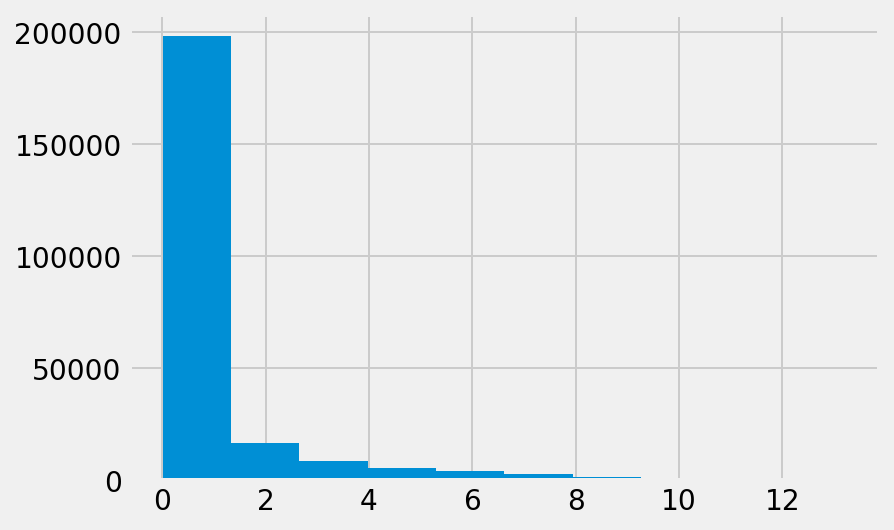

In [90]:
model_df['fire_size_log1'].hist();

#### Log 1 normalized

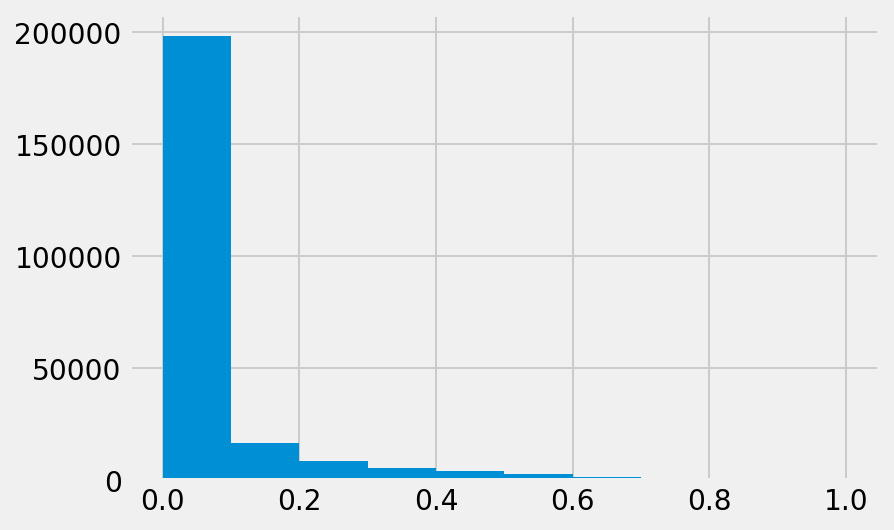

In [91]:
model_df['fire_size_log1_norm'].hist();

#### Cube root

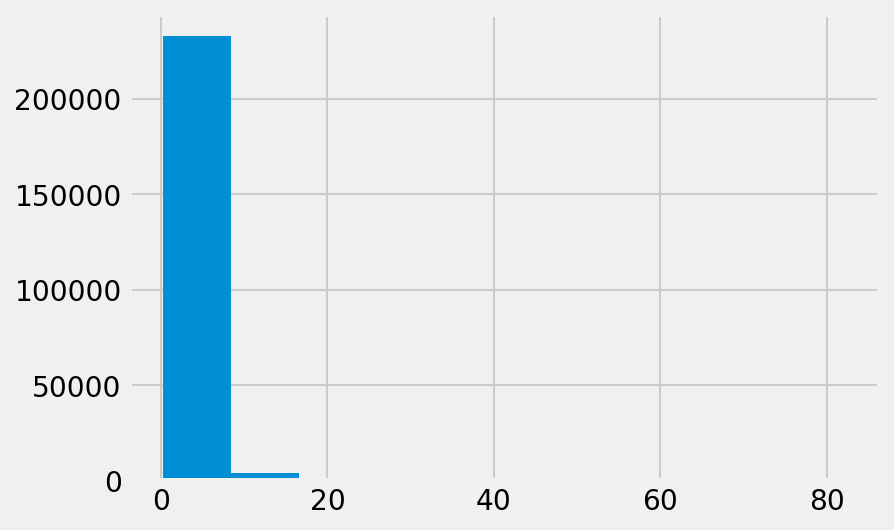

In [92]:
model_df['fire_size_cubert'].hist();

#### Log max

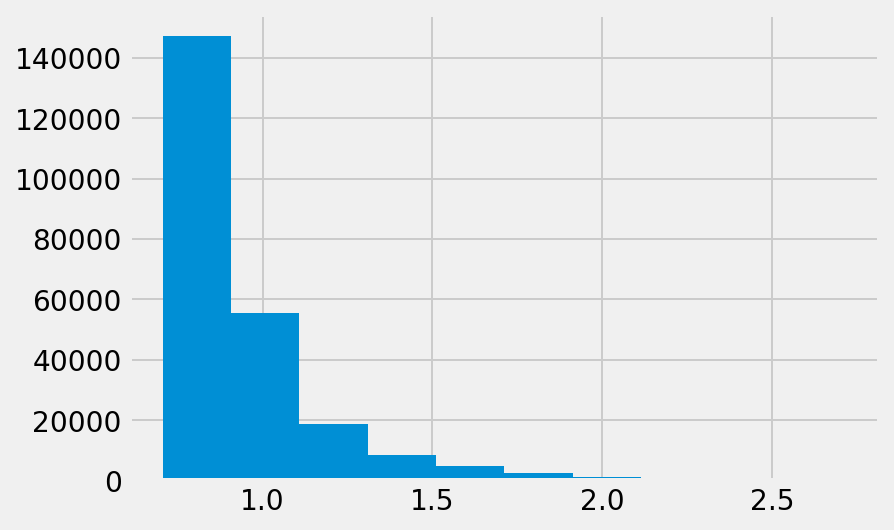

In [93]:
model_df['fire_size_logmax'].hist();

#### Prepare log normal modeling data.

In [94]:
#create X and y variables
X_log = model_df[[ 'pcp', 'tavg', 'pdsi', 'phdi', 'zndx', 'pmdi', 'sp02',
       'sp03', 'sp06', 'sp09', 'sp12', 'sp24', 'tmin', 'tmax', 'month_2', 'month_3',
       'month_4', 'month_5', 'cdd', 'hdd','month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 
       'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11',
       'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16',
       'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21',
       'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26',
       'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31',
       'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36',
       'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41',
       'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46',
       'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51',
       'cluster_52', 'cluster_53', 'cluster_54', 'cluster_55', 'cluster_56',
       'cluster_57', 'cluster_58', 'cluster_59', 'cluster_60', 'cluster_61',
       'cluster_62', 'cluster_63', 'cluster_64', 'cluster_65', 'cluster_66',
       'cluster_67', 'cluster_68', 'cluster_69', 'cluster_70', 'cluster_71',
       'cluster_72', 'cluster_73', 'cluster_74', 'cluster_75', 'cluster_76',
       'cluster_77', 'cluster_78', 'cluster_79', 'cluster_80', 'cluster_81',
       'cluster_82', 'cluster_83', 'cluster_84', 'cluster_85', 'cluster_86',
       'cluster_87', 'cluster_88', 'cluster_89', 'cluster_90', 'cluster_91',
       'cluster_92', 'cluster_93', 'cluster_94', 'cluster_95', 'cluster_96',
       'cluster_97', 'cluster_98', 'cluster_99', 'cluster_100', 'cluster_101',
       'cluster_102', 'cluster_103', 'cluster_104', 'cluster_105',
       'cluster_106', 'cluster_107', 'cluster_108', 'cluster_109',
       'cluster_110', 'cluster_111', 'cluster_112', 'cluster_113',
       'cluster_114', 'cluster_115', 'cluster_116', 'cluster_117',
       'cluster_118', 'cluster_119', 'cluster_120', 'cluster_121',
       'cluster_122', 'cluster_123', 'cluster_124', 'cluster_125',
       'cluster_126', 'cluster_127', 'cluster_128', 'cluster_129',
       'cluster_130', 'cluster_131', 'cluster_132', 'cluster_133',
       'cluster_134', 'cluster_135', 'cluster_136', 'cluster_137',
       'cluster_138', 'cluster_139', 'cluster_140', 'cluster_141',
       'cluster_142', 'cluster_143', 'cluster_144', 'cluster_145',
       'cluster_146', 'cluster_147', 'cluster_148', 'cluster_149',
       'cluster_150', 'cluster_151', 'cluster_152', 'cluster_153',
       'cluster_154', 'cluster_155', 'cluster_156', 'cluster_157',
       'cluster_158', 'cluster_159', 'cluster_160', 'cluster_161',
       'cluster_162', 'cluster_163', 'cluster_164', 'cluster_165',
       'cluster_166', 'cluster_167', 'cluster_168', 'cluster_169',
       'cluster_170', 'cluster_171', 'cluster_172', 'cluster_173',
       'cluster_174', 'cluster_175', 'cluster_176', 'cluster_177',
       'cluster_178', 'cluster_179', 'cluster_180', 'cluster_181',
       'cluster_182', 'cluster_183', 'cluster_184', 'cluster_185',
       'cluster_186', 'cluster_187', 'cluster_188', 'cluster_189',
       'cluster_190', 'cluster_191', 'cluster_192', 'cluster_193',
       'cluster_194', 'cluster_195', 'cluster_196', 'cluster_197',
       'cluster_198', 'cluster_199',
                 'tavg_t12m',
       'tavg_t9m', 'tavg_t6m', 'tavg_t3m', 'pcp_t12m', 'pcp_t9m', 'pcp_t6m',
       'pcp_t3m', 'pmdi_t12m', 'pmdi_t9m', 'pmdi_t6m', 'pmdi_t3m', 'pdsi_t12m',
       'pdsi_t9m', 'pdsi_t6m', 'pdsi_t3m']]
y_log = model_df[['fire_size_log']]

assert len(X_log) == len(y_log)

In [95]:
#split into training and test groups
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, random_state = 42, test_size=.2, train_size = .8)

# Models

# Model #1, OLS, not scaled. As baseline for regression.

### Normal

In [96]:
#Instantiate, fit and score 
lr = LinearRegression()
lr.fit(X=X_train, y=y_train)
print(f' Unscaled Linear Regression training R^2 score: {round(lr.score(X=X_train, y=y_train),4)}')
print(f' Unscaled Linear Regression test R^2 score: {round(lr.score(X_test, y_test),4)}')

 Unscaled Linear Regression training R^2 score: 0.0074
 Unscaled Linear Regression test R^2 score: 0.005


### Log Transform

In [97]:
#Instantiate, fit and score 
lr_log = LinearRegression()
lr_log.fit(X=X_train_log, y=y_train_log)
print(f' Unscaled Linear Regression training R^2 score: {round(lr_log.score(X=X_train_log, y=y_train_log),4)}')
print(f' Unscaled Linear Regression test R^2 score: {round(lr_log.score(X_test_log, y_test_log),4)}')

 Unscaled Linear Regression training R^2 score: 0.1359
 Unscaled Linear Regression test R^2 score: 0.1311


The log transform of the target gives the model a noticeable improvement. I will move forward with evaluation with the log transform fire size as target.

# Model #2, Statsmodel for stastical significance testing

#### Normal

In [59]:
#fit model
X = sm.add_constant(X)
ols = sm.OLS(y, X).fit()

In [60]:
#let's take a quick look at the summary stats of our ordinary least squares
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              fire_size   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     10.68
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:31:14   Log-Likelihood:            -4.0312e+06
No. Observations:              420167   AIC:                         8.063e+06
Df Residuals:                  419940   BIC:                         8.065e+06
Df Model:                         226                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -851.8339    304.452     -2.798      0.005   -1448.550    -255.118
pcp             6.2703     13.013      0.482      0.630     -19.234      31.775
tavg         -236.4222    158.426     -1.492      0.136    -546.932      74.088
pdsi           -6.4315      6.279     -1.024      0.306     -18.738       5.875
phdi          -13.2782     11.440     -1.161      0.246     -35.701       9.145
zndx            6.4743      7.084      0.914      0.361      -7.410      20.359
pmdi            2.9520     13.795      0.214      0.831     -24.086      29.990
sp02           20.4443     11.013      1.856      0.063      -1.140      42.029
sp03          -47.3049     11.057     -4.278      0.000     -68.977     -25.633
sp06           30.6286     10.040      3.051      0.002      10.951      50.306
sp09          -39.1272     14.369     -2.723      0.006     -67.291     -10.964
sp12           13.0027     14.218      0.914      0.360     -14.865      40.870
sp24           50.8661      8.057      6.314      0.000      35.075      66.657
tmin           89.1364     79.322      1.124      0.261     -66.332     244.605
tmax          151.8410     79.506      1.910      0.056      -3.988     307.670
month_2        -3.0679     76.671     -0.040      0.968    -153.340     147.204
month_3       -91.7988     68.170     -1.347      0.178    -225.410      41.812
month_4      -121.8445     69.891     -1.743      0.081    -258.829      15.140
month_5      -162.9771     79.104     -2.060      0.039    -318.019      -7.935
cdd             0.1371      0.130      1.058      0.290      -0.117       0.391
hdd            -0.0031      0.147     -0.021      0.983      -0.292       0.285
month_6      -190.2661     91.215     -2.086      0.037    -369.045     -11.487
month_7      -223.9040    101.641     -2.203      0.028    -423.117     -24.691
month_8      -195.7834     98.928     -1.979      0.048    -389.679      -1.888
month_9      -268.2115     88.217     -3.040      0.002    -441.114     -95.309
month_10      -72.7621     74.236     -0.980      0.327    -218.262      72.737
month_11      -21.5000     71.137     -0.302      0.762    -160.926     117.926
month_12       45.4875     83.982      0.542      0.588    -119.114     210.089
cluster_0     335.3228     89.048      3.766      0.000     160.792     509.853
cluster_1    -289.5465     62.720     -4.617      0.000    -412.475    -166.618
cluster_2     -22.7798     72.107     -0.316      0.752    -164.108     118.548
cluster_3    -177.1592     76.958     -2.302      0.021    -327.994     -26.324
cluster_4      44.6190     61.510      0.725      0.468     -75.939     165.177
cluster_5     182.7611     70.229      2.602      0.009      45.115     320.407
cluster_6    -228.4645    114.033     -2.004      0.045    -451.965      -4.964
cluster_7     -36.2134     78.844     -0.45

#### The above shows what we excpect. That certain cluster locations have more significant impact on the explained variance than others. Some places have more fires than other places. These places tend to be more densely forested.

#### Log Transform

In [61]:
#fit model
X = sm.add_constant(X_log)
ols = sm.OLS(y_log, X_log).fit()

In [62]:
#let's take a quick look at the summary stats of our ordinary least squares
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fire_size_log   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     266.2
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:31:35   Log-Likelihood:            -9.2051e+05
No. Observations:              420167   AIC:                         1.841e+06
Df Residuals:                  419940   BIC:                         1.844e+06
Df Model:                         226                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
pcp            -0.0148      0.008     -1.870      0.062      -0.030       0.001
tavg           -0.1944      0.097     -2.015      0.044      -0.384      -0.005
pdsi            0.0098      0.004      2.567      0.010       0.002       0.017
phdi            0.0201      0.007      2.886      0.004       0.006       0.034
zndx           -0.0061      0.004     -1.407      0.159      -0.015       0.002
pmdi            0.0270      0.008      3.216      0.001       0.011       0.043
sp02            0.0133      0.007      1.978      0.048       0.000       0.026
sp03           -0.0890      0.007    -13.210      0.000      -0.102      -0.076
sp06           -0.0166      0.006     -2.708      0.007      -0.029      -0.005
sp09           -0.0841      0.009     -9.604      0.000      -0.101      -0.067
sp12           -0.0548      0.009     -6.322      0.000      -0.072      -0.038
sp24            0.1042      0.005     21.234      0.000       0.095       0.114
tmin            0.0420      0.048      0.869      0.385      -0.053       0.137
tmax            0.1580      0.048      3.263      0.001       0.063       0.253
month_2         0.2655      0.047      5.685      0.000       0.174       0.357
month_3         0.4936      0.042     11.887      0.000       0.412       0.575
month_4         0.4789      0.043     11.250      0.000       0.396       0.562
month_5         0.2518      0.048      5.226      0.000       0.157       0.346
cdd             0.0009   7.89e-05     11.870      0.000       0.001       0.001
hdd             0.0008   8.96e-05      8.700      0.000       0.001       0.001
month_6         0.1646      0.056      2.963      0.003       0.056       0.274
month_7        -0.0551      0.062     -0.890      0.374      -0.176       0.066
month_8         0.0639      0.060      1.061      0.289      -0.054       0.182
month_9        -0.0178      0.054     -0.332      0.740      -0.123       0.087
month_10        0.2689      0.045      5.947      0.000       0.180       0.358
month_11        0.2729      0.043      6.297      0.000       0.188       0.358
month_12        0.0122      0.051      0.238      0.812      -0.088       0.112
cluster_0      -3.5106      0.189    -18.606      0.000      -3.880      -3.141
cluster_1      -3.2315      0.183    -17.684      0.000      -3.590      -2.873
cluster_2      -3.1177      0.194    -16.054      0.000      -3.498      -2.737
cluster_3      -3.6084      0.196    -18.427      0.000      -3.992      -3.225
cluster_4      -3.2334      0.189    -17.103      0.000      -3.604      -2.863
cluster_5      -1.8154      0.197     -9.208      0.000      -2.202      -1.429
cluster_6      -3.4784      0.193    -18.008      0.000      -3.857      -3.100
cluster_7      -3.5630      0.195    -18.243      0.000      -3.946      -3.180
cluster_8      -4.1359      0.198    -20.86

#### There is loss in interperability with the log transformed target.

# Model #3, Linear Regression, scaled

#### Normal

In [63]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [64]:
lr_stan = LinearRegression()
lr_stan.fit(Z_train, y_train)
print(f' Scaled Linear Regression training R^2 score: {round(lr_stan.score(Z_train, y_train),4)}')
print(f' Scaled Linear Regression test R^2 score: {round(lr_stan.score(Z_test, y_test),4)}')

 Scaled Linear Regression training R^2 score: 0.0058
 Scaled Linear Regression test R^2 score: 0.0042


##### There is no noteable change in R^2 after scaling. Feature scale may not be an issue.

#### Log Transform

In [65]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_log)
Z_test = sc.transform(X_test_log)

In [66]:
lr_stan = LinearRegression()
lr_stan.fit(Z_train, y_train_log)
print(f' Scaled Linear Regression training R^2 score: {round(lr_stan.score(Z_train, y_train_log),4)}')
print(f' Scaled Linear Regression test R^2 score: {round(lr_stan.score(Z_test, y_test_log),4)}')

 Scaled Linear Regression training R^2 score: 0.126
 Scaled Linear Regression test R^2 score: 0.1218


# Model #4, Lasso Gridsearch, basic

#### Normal

In [67]:
lasso_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lassocv', Lasso())
])

In [68]:
#set up lasso parameters to use grid search
lasso_params = {'lassocv__alpha':np.logspace(0, 3, 1000),
               'lassocv__max_iter':[10000],
               }
# we use gridsearch instead of LassoCV to take advantage of multiple cores
lasso_gridsearch = GridSearchCV(estimator = Lasso(max_iter = 100000),
                                param_grid = lasso_params,
                                verbose = 2,
                                cv = 5,
                                scoring = 'r2',
                                n_jobs = -1)

In [69]:
lasso_gridsearch.fit(X_train, y_train)
lasso_gridsearch.best_estimator_

NameError: name 'lasso_pipe_gridsearch' is not defined

In [ ]:
# BEST PARAMS
# Pipeline(memory=None,
#          steps=[('sc',
#                  StandardScaler(copy=True, with_mean=True, with_std=True)),
#                 ('lassocv',
#                  Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
#                        max_iter=10000, normalize=False, positive=False,
#                        precompute=False, random_state=None, selection='cyclic',
#                        tol=0.0001, warm_start=True))],
#          verbose=False)

##### Coef_ eval

In [ ]:
lasso_sc = StandardScaler()
lasso_Z_train = lasso_sc.fit_transform(X_train)
lasso_Z_test = lasso_sc.fit_transform(X_test)

In [ ]:
lasso_coef_eval = Lasso(alpha = 1, max_iter=10000)

In [ ]:
print(lasso_Z_train.shape)
print(y_train.shape)

In [ ]:
lasso_coef_eval.fit(lasso_Z_train, y_train)
print(f'Lasso R^2 Cross Validated Score: {round(cross_val_score(lasso_coef_eval, lasso_Z_train, y_train).mean(),4)}') 

In [ ]:
lasso_coef_eval.intercept_

In [ ]:
feature_importance = pd.DataFrame(list(zip(X_train.columns, lasso_coef_eval.coef_)))
feature_importance

#### Log Transform

In [ ]:
lasso_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('lassocv', Lasso())
])

In [ ]:
lasso_params = {'lassocv__alpha':np.logspace(0, 3, 1000),
               'lassocv__max_iter':[1000],
               }

In [ ]:
%%time
lasso_pipe_gridsearch = GridSearchCV(lasso_pipe, 
                                param_grid=lasso_params,
                                verbose = 2,
                                #cv = 5,
                                scoring = 'r2',
                                n_jobs = -1
                                )

In [ ]:
%%time
lasso_pipe_gridsearch.fit(X_train_log, y_train_log)

In [ ]:
lasso_pipe_gridsearch.best_estimator_

##### Coef_eval

In [ ]:
lasso_sc = StandardScaler()
lasso_Z_train = lasso_sc.fit_transform(X_train_log)
lasso_Z_test = lasso_sc.fit_transform(X_test_log)

In [ ]:
lasso_coef_eval = Lasso(alpha = 1, max_iter=10000)

In [ ]:
print(lasso_Z_train.shape)
print(y_train_log.shape)

In [ ]:
lasso_coef_eval.fit(lasso_Z_train, y_train_log)
print(f'Lasso R^2 Cross Validated Score: {round(cross_val_score(lasso_coef_eval, lasso_Z_train, y_train_log).mean(),4)}') 

In [ ]:
lasso_coef_eval.intercept_

In [ ]:
feature_importance = pd.DataFrame(list(zip(X_train_log.columns, lasso_coef_eval.coef_)))
feature_importance
# The L1 penalty is not kind.

# Model #5, RidgeCV, L1 penalty is not kind to our model. Trying L2.

#### Log Transform

Exploring L2. If I like L2 I will run RidgeCV for polynomial features

In [70]:
%%time
# Set up a list of ridge alphas to check.
# np.logspace generates 100 values equally between 0 and 5,
# then converts them to alphas between 10^0 and 10^5.
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha!
ridge_cv.fit(Z_train, y_train_log);

Wall time: 11min 13s


RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       6.89261210e+03, 7.74263683e+03, 8.69749003e+03, 9.77009957e+03,
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, scoring='r2')

In [71]:
# Here is the optimal value of alpha
alpha = ridge_cv.alpha_
print(alpha)

3.5938136638046276


In [72]:
print(f' RidgeCV Regression training R^2 score: {round(ridge_cv.score(Z_train, y_train_log),4)}')
print(f' RidgeCV Regression test R^2 score: {round(ridge_cv.score(Z_test, y_test_log),4)}')

 RidgeCV Regression training R^2 score: 0.126
 RidgeCV Regression test R^2 score: 0.1218


#### Coef_eval

In [73]:
ridge = Ridge(alpha = 0.1, normalize = True, max_iter = 5000)

In [74]:
# Fit model using best ridge alpha!
ridge.fit(Z_train, y_train_log);

In [75]:
ridge.coef_

array([[-9.80285970e-02,  1.34609595e-02,  3.84045196e-02,
         5.59759185e-02, -2.20640077e-02,  4.63540580e-02,
        -1.55655518e-02, -7.00305637e-02, -2.01329697e-02,
        -5.54413097e-02, -4.83555794e-02,  1.02262061e-01,
        -4.77646417e-02,  6.70740812e-02,  9.51489885e-03,
         5.33706939e-02,  6.26418808e-02,  3.45520939e-02,
         1.19557772e-01,  5.14514193e-02,  3.66325860e-02,
        -3.91386270e-02,  4.08382606e-03, -3.24663047e-02,
         1.66686858e-02,  4.05412345e-04, -1.74694742e-02,
        -5.88651942e-03,  1.65524623e-02,  8.23670143e-03,
        -1.46173613e-02,  6.93165895e-03,  1.15657051e-01,
        -3.14825109e-03, -2.17411738e-02, -5.22580539e-02,
         2.77725616e-02,  1.05490128e-01, -1.90733966e-04,
        -4.99051191e-02, -3.75993221e-02, -8.08831862e-03,
         1.33452660e-01, -3.33400369e-02, -1.76831247e-02,
         3.22559497e-02,  2.34420660e-02,  2.48283826e-02,
        -1.69550205e-02,  2.39875895e-02, -1.44208432e-0

# Model #6, Elastic-Search Gridsearch, Exploring Polynomial Features

#### Log Transform

In [88]:
pipe_mario = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('sc', StandardScaler()),
            ('elasticnet', ElasticNet())
                        ])

In [89]:
parameters_mario = {'elasticnet__alpha': np.logspace(0, 4, 500),
                      'elasticnet__normalize': [True, False],
                      'elasticnet__selection': ['cyclic', 'random'],
                        'elasticnet__max_iter': [10000],
                        #'elasticnet__tol': [.1]
                       }

In [90]:
elastic_net_model = GridSearchCV(
                pipe_mario, 
                param_grid= parameters_mario,
                verbose = 2,
                #cv = 5,
                scoring = 'r2',
                n_jobs = -1
                )
elastic_net_model.fit(X_train_log, y_train_log)
elastic_net_model.best_estimator_

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.6min


KeyboardInterrupt: 

In [ ]:
print(f'ElasticNet Model R^2 Score: {round(elastic_net_model.best_score_,4)}')

In [95]:
pipe_mario_ridge = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('sc', StandardScaler()),
            ('ridge', RidgeCV())
                        ])

In [98]:
parameters_mario_ridge = {#'ridge__alphas': [1],
                      #'ridge__normalize': [True, False],
                      #'ridge__selection': ['cyclic', 'random'],
                        #'ridge__max_iter': [10000],
                        #'elasticnet__tol': [.1]
                       }

In [99]:
elastic_net_model = GridSearchCV(
                pipe_mario_ridge, 
                param_grid= parameters_mario_ridge,
                verbose = 2,
                #cv = 5,
                scoring = 'r2',
                n_jobs = -1
                )
elastic_net_model.fit(X_train_log, y_train_log)
elastic_net_model.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


RuntimeError: Cannot clone object RidgeCV(alphas=1), as the constructor either does not set or modifies parameter alphas

### With polynomial features = 2

In [76]:
trans = PolynomialFeatures(degree=2)
data_train_trans = trans.fit_transform(X_train)
data_test_trans = trans.fit_transform(X_test)

MemoryError: Unable to allocate 65.4 GiB for an array with shape (336133, 26106) and data type float64

In [ ]:
ridge_poly = Ridge()

In [ ]:
ridge_poly.fit(X=data_train_trans, y=y_train_log)

In [ ]:
ridge_poly.score(X=data_train_trans, y=y_train_log)

In [ ]:
ridge_poly.score(X=data_test_trans, y=y_test_log)